In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import glob
import random


# Parameters
dataset_url = r'C:\Users\abudh\Desktop\CropWatch\Platform1_D2\DataSet1'  # Path to the dataset
batch_size = 20  # Number of images to process in a batch during training
img_height = 224  # Height to which images will be resized
img_width = 224  # Width to which images will be resized
validation_split = 0.2  # 20% of the data will be used for validation
rescale = 1.0 / 255  # Normalize pixel values to the range [0, 1]
no_epochs = 100  # Number of epochs to train the model

# Data Augmentation and Loading

    # Note: Data augmentation is applied on-the-fly, which means the number of images on disk does not increase.
    # Each image is augmented differently each time it is used in training, but the total number of images on disk remains the same.

datagen = ImageDataGenerator(
    rescale=rescale,  # Rescale pixel values
    rotation_range=40,  # Randomly rotate images by up to 40 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by up to 20%
    height_shift_range=0.2,  # Randomly shift images vertically by up to 20%
    shear_range=0.2,  # Apply shear transformations with a shear intensity of 0.2
    zoom_range=0.2,  # Randomly zoom into images by up to 20%
    horizontal_flip=True,  # Randomly flip images horizontally
    vertical_flip=True,  # Randomly flip images vertically
    brightness_range=[0.8, 1.2],  # Randomly adjust brightness between 80% and 120%
    channel_shift_range=0.2,  # Randomly shift color channels
    fill_mode='nearest',  # Fill in missing pixels after transformations using the nearest pixel values
    validation_split=validation_split  # Reserve 20% of the data for validation
)

"""

# Initialize ImageDataGenerator without augmentation
datagen = ImageDataGenerator(
    rescale=rescale,  # Rescale pixel values
    validation_split=validation_split  # Reserve 20% of the data for validation
)
"""

# Load and augment the training dataset
train_dataset = datagen.flow_from_directory(
    directory=dataset_url,  # Path to the dataset directory
    target_size=(img_height, img_width),  # Resize images to the target size
    batch_size=batch_size,  # Number of images per batch
    subset="training",  # Specify that this is the training subset
    class_mode='binary'  # Class mode ('binary' indicates two classes)
)

# Load and augment the validation dataset
test_dataset = datagen.flow_from_directory(
    directory=dataset_url,  # Path to the dataset directory
    target_size=(img_height, img_width),  # Resize images to the target size
    batch_size=batch_size,  # Number of images per batch
    subset="validation",  # Specify that this is the validation subset
    class_mode='binary'  # Class mode ('binary' indicates two classes)
)

# Compute class weights to handle class imbalance
class_indices = train_dataset.class_indices  # Get the mapping of class names to indices
class_weights = compute_class_weight(
    class_weight='balanced',  # Compute weights inversely proportional to class frequencies
    classes=np.array(list(class_indices.values())),  # Get the class indices (0 and 1)
    y=train_dataset.classes  # Get the class labels for all training images
)
class_weight_dict = dict(enumerate(class_weights))  # Convert the weights into a dictionary for use during training


Found 568 images belonging to 2 classes.
Found 141 images belonging to 2 classes.


In [5]:
# Define the ResNet50 model

# Define the Identity Block of ResNet
def identity_block(X, f, filters, training=True, initializer=glorot_uniform):
    """
    Builds an identity block with three convolutional layers and a skip connection.
    
    Parameters:
    - X: Input tensor to the block.
    - f: The size of the convolutional kernels in the second convolutional layer.
    - filters: List of integers specifying the number of filters in the convolutional layers.
    - training: Boolean, whether the model is in training mode (affects BatchNormalization).
    - initializer: Function to initialize the kernel weights of the layers.
    
    Returns:
    - X: Output tensor from the identity block.
    """
    F1, F2, F3 = filters
    X_shortcut = X
    
    # First convolution layer
    X = Conv2D(filters=F1, kernel_size=1, strides=(1, 1), padding='valid', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)
    
    # Second convolution layer
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)
    
    # Third convolution layer
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    
    # Add shortcut connection
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X, training=training)
    
    return X

# Define the Convolutional Block of ResNet
def convolutional_block(X, f, filters, s=2, training=True, initializer=glorot_uniform):
    """
    Builds a convolutional block with three convolutional layers and a shortcut with downsampling.
    
    Parameters:
    - X: Input tensor to the block.
    - f: The size of the convolutional kernels in the second convolutional layer.
    - filters: List of integers specifying the number of filters in the convolutional layers.
    - s: The stride for the first convolutional layer (used for downsampling).
    - training: Boolean, whether the model is in training mode (affects BatchNormalization).
    - initializer: Function to initialize the kernel weights of the layers.
    
    Returns:
    - X: Output tensor from the convolutional block.
    """
    F1, F2, F3 = filters
    X_shortcut = X
    
    # First convolution layer (downsampling)
    X = Conv2D(filters=F1, kernel_size=1, strides=(s, s), padding='valid', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)
    
    # Second convolution layer
    X = Conv2D(F2, (f, f), strides=(1, 1), padding='same', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)
    
    # Third convolution layer
    X = Conv2D(F3, (1, 1), strides=(1, 1), padding='valid', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    
    # Adjust shortcut path to match dimensions
    X_shortcut = Conv2D(F3, (1, 1), strides=(s, s), padding='valid', kernel_initializer=initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut, training=training)
    
    # Add shortcut connection
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

# Define the ResNet50 model
def ResNet50(input_shape=(img_height, img_width, 3)):
    """
    Builds the ResNet50 model using identity and convolutional blocks.
    
    Parameters:
    - input_shape: Tuple specifying the shape of the input images (height, width, channels).
    
    Returns:
    - model: A Keras Model instance for ResNet50.
    """
    X_input = Input(input_shape)
    
    # Initial layers
    X = ZeroPadding2D((3, 3))(X_input)
    X = Conv2D(64, (7, 7), strides=(2, 2), kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    
    # Residual blocks
    X = convolutional_block(X, f=3, filters=[64, 64, 256], s=1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
    
    X = convolutional_block(X, f=3, filters=[128, 128, 512], s=2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], s=2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], s=2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])
    
    # Final layers
    X = AveragePooling2D(pool_size=(2, 2), name='avg_pool')(X)
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', kernel_initializer=glorot_uniform(seed=0))(X)
    
    model = Model(inputs=X_input, outputs=X)
    return model

# Learning Rate Reduction Callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=15,
    verbose=1,
    min_lr=1e-6
)
"""
This callback reduces the learning rate by half if the validation loss plateaus for 15 epochs.
This helps the model converge better by taking smaller steps as it approaches the minimum of the loss function.
"""

# Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=30,
    verbose=1,
    restore_best_weights=True
)
"""
This callback stops training if the validation loss does not improve for 30 epochs.
It also restores the model weights to the best state observed during training to prevent overfitting.
"""

# Path for saving models
model_path = r'C:\Users\abudh\Desktop\CropWatch'

# Dynamic Model Checkpoint Callback
dynamic_checkpoint_callback = ModelCheckpoint(
    filepath=model_path + r'\Training_model_epoch_16_08_Platform1_{epoch:02d}.weights.h5',  # Use .weights.h5 extension
    save_freq='epoch',
    save_weights_only=True,
    verbose=1
)
"""
This callback saves the model's weights at the end of each epoch. This is useful for resuming training or for checking the model’s progress.
"""

# Best Model Checkpoint Callback
best_model_checkpoint_callback = ModelCheckpoint(
    filepath=model_path + r'\best_weights_16_08_Platform1_.weights.h5',  # Use .weights.h5 extension
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)
"""
This callback saves the model's weights only if the validation loss improves. This ensures that only the best model weights are kept.
"""

# Load and compile the model
model = ResNet50(input_shape=(img_height, img_width, 3))
"""
Instantiate the ResNet50 model with the given input shape. Ensure that `img_height` and `img_width` are defined before this call.
"""


In [3]:
# Define the ResNet50 model

def identity_block(X, f, filters, training=True, initializer=glorot_uniform):
    """
    Define an identity block in the ResNet architecture. This block allows the network to learn residual mappings
    while preserving the input information.
    
    Parameters:
    - X: Input tensor.
    - f: Size of the middle convolutional layer.
    - filters: List containing the number of filters for each convolutional layer.
    - training: Boolean indicating whether the model is in training mode (for BatchNormalization).
    - initializer: Function to initialize the weights.
    
    Returns:
    - X: Output tensor of the identity block.
    """
    F1, F2, F3 = filters
    X_shortcut = X  # Save the input for the residual connection
    
    # First convolutional layer with 1x1 kernel, padding 'valid'
    X = Conv2D(filters=F1, kernel_size=1, strides=(1, 1), padding='valid', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)  # Batch Normalization
    X = Activation('relu')(X)  # ReLU Activation
    
    # Second convolutional layer with fxf kernel, padding 'same'
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)  # Batch Normalization
    X = Activation('relu')(X)  # ReLU Activation
    
    # Third convolutional layer with 1x1 kernel, padding 'valid'
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)  # Batch Normalization
    
    # Add the shortcut connection (residual connection) to the output of this block
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X, training=training)  # ReLU Activation
    
    return X

def convolutional_block(X, f, filters, s=2, training=True, initializer=glorot_uniform):
    """
    Define a convolutional block in the ResNet architecture. This block includes convolutional layers that change
    the dimensions of the feature maps and includes a residual connection.
    
    Parameters:
    - X: Input tensor.
    - f: Size of the middle convolutional layer.
    - filters: List containing the number of filters for each convolutional layer.
    - s: Stride for the first convolutional layer.
    - training: Boolean indicating whether the model is in training mode (for BatchNormalization).
    - initializer: Function to initialize the weights.
    
    Returns:
    - X: Output tensor of the convolutional block.
    """
    F1, F2, F3 = filters
    X_shortcut = X  # Save the input for the residual connection
    
    # First convolutional layer with 1x1 kernel and stride (s, s)
    X = Conv2D(filters=F1, kernel_size=1, strides=(s, s), padding='valid', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)  # Batch Normalization
    X = Activation('relu')(X)  # ReLU Activation
    
    # Second convolutional layer with fxf kernel, padding 'same'
    X = Conv2D(F2, (f, f), strides=(1, 1), padding='same', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)  # Batch Normalization
    X = Activation('relu')(X)  # ReLU Activation
    
    # Third convolutional layer with 1x1 kernel
    X = Conv2D(F3, (1, 1), strides=(1, 1), padding='valid', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)  # Batch Normalization
    
    # Adjust the shortcut connection to match the dimensions of X
    X_shortcut = Conv2D(F3, (1, 1), strides=(s, s), padding='valid', kernel_initializer=initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut, training=training)
    
    # Add the shortcut connection (residual connection) to the output of this block
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)  # ReLU Activation
    
    return X

def ResNet50(input_shape=(img_height, img_width, 3)):
    """
    Define the ResNet50 model architecture. This model uses residual connections to facilitate the training
    of very deep networks.
    
    Parameters:
    - input_shape: Shape of the input images.
    
    Returns:
    - model: The compiled ResNet50 model.
    """
    X_input = Input(input_shape)  # Input layer
    
    # Initial layers
    X = ZeroPadding2D((3, 3))(X_input)  # Padding to maintain spatial dimensions
    X = Conv2D(64, (7, 7), strides=(2, 2), kernel_initializer=glorot_uniform(seed=0))(X)  # Initial Convolution
    X = BatchNormalization(axis=3)(X)  # Batch Normalization
    X = Activation('relu')(X)  # ReLU Activation
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)  # Max Pooling
    
    # Residual blocks
    X = convolutional_block(X, f=3, filters=[64, 64, 256], s=1)  # First convolutional block
    X = identity_block(X, 3, [64, 64, 256])  # Identity blocks
    X = identity_block(X, 3, [64, 64, 256])
    X = convolutional_block(X, f=3, filters=[128, 128, 512], s=2)  # Second convolutional block
    X = identity_block(X, 3, [128, 128, 512])  # Identity blocks
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], s=2)  # Third convolutional block
    X = identity_block(X, 3, [256, 256, 1024])  # Identity blocks
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], s=2)  # Fourth convolutional block
    X = identity_block(X, 3, [512, 512, 2048])  # Identity blocks
    X = identity_block(X, 3, [512, 512, 2048])
    
    # Final layers
    X = AveragePooling2D(pool_size=(2, 2), name='avg_pool')(X)  # Average Pooling
    X = Flatten()(X)  # Flatten the tensor
    X = Dense(1, activation='sigmoid', kernel_initializer=glorot_uniform(seed=0))(X)  # Dense layer for binary classification
    
    model = Model(inputs=X_input, outputs=X)  # Create the model
    return model

# Define learning rate reduction callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.5,  # Reduce learning rate by a factor of 0.5
    patience=15,  # Wait for 15 epochs before reducing learning rate
    verbose=1,  # Print messages when learning rate is reduced
    min_lr=1e-6  # Minimum learning rate
)

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=30,  # Stop training if no improvement for 30 epochs
    verbose=1,  # Print messages when early stopping is triggered
    restore_best_weights=True  # Restore weights from the epoch with the best validation loss
)

# Define model checkpoint callback to save model weights
model_path = r'C:\Users\abudh\Desktop\CropWatch'
dynamic_checkpoint_callback = ModelCheckpoint(
    filepath=model_path + r'\Training_model_epoch_16_08_Platform1_{epoch:02d}.weights.h5',  # Save weights with epoch number
    save_freq='epoch',  # Save weights after each epoch
    save_weights_only=True,  # Only save model weights
    verbose=1  # Print messages when weights are saved
)

# Define model checkpoint callback to save the best model weights
best_model_checkpoint_callback = ModelCheckpoint(
    filepath=model_path + r'\best_weights_16_08_Platform1_.weights.h5',  # Save weights of the best model
    monitor='val_loss',  # Monitor validation loss
    mode='min',  # Save weights when validation loss is minimized
    save_best_only=True,  # Save only the best weights
    save_weights_only=True,  # Only save model weights
    verbose=1  # Print messages when best weights are saved
)

# Compile and train the model
model = ResNet50(input_shape=(img_height, img_width, 3))  # Initialize the ResNet50 model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Compile the model with Adam optimizer
              loss='binary_crossentropy',  # Binary crossentropy loss for binary classification
              metrics=['accuracy'])  # Metric to evaluate during training

# Train the model
history = model.fit(
    train_dataset,  # Training dataset
    epochs=no_epochs,  # Number of epochs to train
    validation_data=test_dataset,  # Validation dataset
    callbacks=[reduce_lr, early_stopping, dynamic_checkpoint_callback, best_model_checkpoint_callback],  # Callbacks for training
    class_weight=class_weight_dict  # Class weights to handle class imbalance
)


Epoch 1/100


C:\Users\abudh\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6975 - loss: 1.0714
Epoch 1: saving model to C:\Users\abudh\Desktop\CropWatch\Training_model_epoch_16_08_Platform1_01.weights.h5

Epoch 1: val_loss improved from inf to 0.69435, saving model to C:\Users\abudh\Desktop\CropWatch\best_weights_16_08_Platform1_.weights.h5
29/29 ━━━━━━━━━━━━━━━━━━━━ 201s 5s/step - accuracy: 0.6995 - loss: 1.0677 - val_accuracy: 0.5390 - val_loss: 0.6943 - learning_rate: 1.0000e-04
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8029 - loss: 0.6218
Epoch 2: saving model to C:\Users\abudh\Desktop\CropWatch\Training_model_epoch_16_08_Platform1_02.weights.h5

Epoch 2: val_loss did not improve from 0.69435
29/29 ━━━━━━━━━━━━━━━━━━━━ 152s 5s/step - accuracy: 0.8022 - loss: 0.6281 - val_accuracy: 0.5390 - val_loss: 0.7162 - learning_rate: 1.0000e-04
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7992 - loss: 1.1440
Epoch 3: saving model to C:\Users\abudh\Desktop\CropWatch\Training_

In [3]:
# Count the number of images in the train and validation datasets
num_train_images = len(train_dataset.filenames)
num_val_images = len(test_dataset.filenames)

# Print the number of images
print(f"Number of training images: {num_train_images}")
print(f"Number of validation images: {num_val_images}")

# Print the classes and their corresponding indices
print(f"Classes found: {train_dataset.class_indices}")

# Print the distribution of classes in the training dataset
class_distribution = np.bincount(train_dataset.classes)
for class_name, class_idx in train_dataset.class_indices.items():
    print(f"Class '{class_name}' (index {class_idx}) has {class_distribution[class_idx]} samples.")

# Print out the computed class weights
print("Class weights:")
for class_idx, weight in class_weight_dict.items():
    print(f"Class {class_idx}: {weight}")


Number of training images: 568
Number of validation images: 141
Classes found: {'NonVegetation': 0, 'Vegetation': 1}
Class 'NonVegetation' (index 0) has 308 samples.
Class 'Vegetation' (index 1) has 260 samples.
Class weights:
Class 0: 0.922077922077922
Class 1: 1.0923076923076922


In [4]:

# Convert the model to TFLite
model.save(r'C:\Users\abudh\Desktop\CropWatch\Training_model_Platform1A.h5')

In [5]:


converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model to disk
with open(r'C:\Users\abudh\Desktop\CropWatch\16_98Training_model_Platform1A.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\abudh\AppData\Local\Temp\tmp7l_rvvpp\assets


INFO:tensorflow:Assets written to: C:\Users\abudh\AppData\Local\Temp\tmp7l_rvvpp\assets


Saved artifact at 'C:\Users\abudh\AppData\Local\Temp\tmp7l_rvvpp'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2102176045520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2100773398160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2100773397200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2100773397776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2100773396816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2100773398352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2100773399312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2100773399120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2100773398544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2100773399888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  21007

In [11]:
# Define the path to the best model weights
best_weights_path = r'C:\Users\abudh\Desktop\CropWatch\best_weights_16_08_Platform1_.weights.h5'

# Create the model structure again (since weights are saved separately)
model = ResNet50(input_shape=(img_height, img_width, 3))

# Load the best weights into the model
model.load_weights(best_weights_path)


# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()


# Save the TFLite model to disk
best_tflite_path = r'C:\Users\abudh\Desktop\CropWatch\best_model_Platform1A.tflite'
with open(best_tflite_path, 'wb') as f:
    f.write(tflite_model)



INFO:tensorflow:Assets written to: C:\Users\abudh\AppData\Local\Temp\tmpq8fvk3up\assets


INFO:tensorflow:Assets written to: C:\Users\abudh\AppData\Local\Temp\tmpq8fvk3up\assets


Saved artifact at 'C:\Users\abudh\AppData\Local\Temp\tmpq8fvk3up'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_501')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2106480924368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2106480924752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2106480925136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2106480922832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2106480922448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2106480924944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2106480926480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2106480927056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2106480926096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2106480926864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2

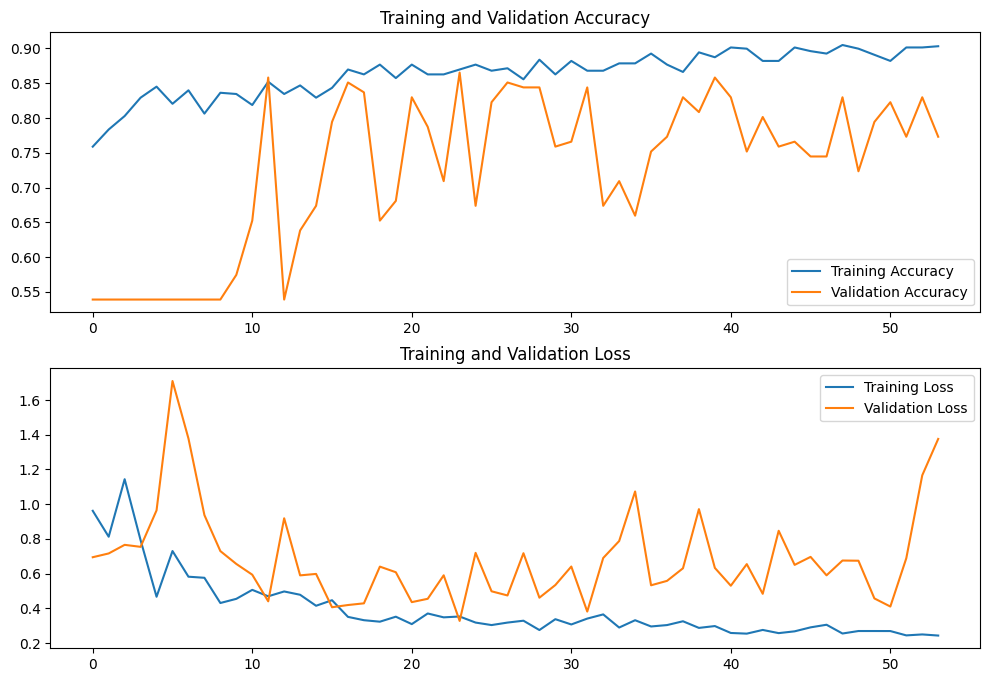

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Plotting training & validation accuracy and loss
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Call the plot function
plot_training_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


C:\Users\abudh\AppData\Local\Temp\ipykernel_22108\3432489297.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  NonVeg_pred.append(int(pred > 0.5))  # Use threshold of 0.5 for binary classification


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━

C:\Users\abudh\AppData\Local\Temp\ipykernel_22108\3432489297.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Veg_pred.append(int(pred > 0.5))  # Use threshold of 0.5 for binary classification


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

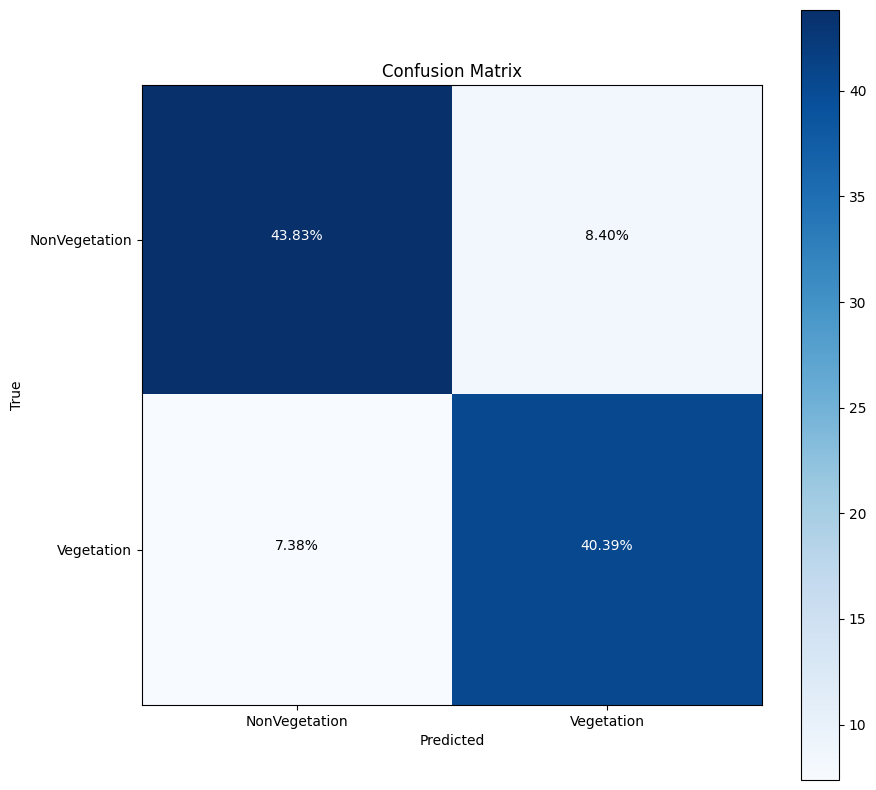

In [12]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image as keras_image
import matplotlib.pyplot as plt
import itertools

# Load the best model weights
best_weights_path = r'C:\Users\abudh\Desktop\CropWatch\best_weights_16_08_Platform1_.weights.h5'
model = ResNet50(input_shape=(224, 224, 3))
model.load_weights(best_weights_path)

# Define paths
NonVeg = glob.glob(r'C:\Users\abudh\Desktop\CropWatch\Platform1\NonVegetation\*.jpeg')
Veg = glob.glob(r'C:\Users\abudh\Desktop\CropWatch\Platform1\Vegetation\*.jpeg')

# Initialize lists for predictions
NonVeg_pred = []
Veg_pred = []

# Function to load and preprocess image
def load_and_preprocess_image(image_path, target_size):
    img = keras_image.load_img(image_path, target_size=target_size)
    img_array = keras_image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Predict Non-Vegetation Images
for image in NonVeg:
    img_array = load_and_preprocess_image(image, target_size=(224, 224))
    pred = model.predict(img_array)
    NonVeg_pred.append(int(pred > 0.5))  # Use threshold of 0.5 for binary classification

# Predict Vegetation Images
for image in Veg:
    img_array = load_and_preprocess_image(image, target_size=(224, 224))
    pred = model.predict(img_array)
    Veg_pred.append(int(pred > 0.5))  # Use threshold of 0.5 for binary classification

# True labels and predicted labels
true_labels = [0] * len(NonVeg_pred) + [1] * len(Veg_pred)
predicted_labels = NonVeg_pred + Veg_pred

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
cm_percentage = cm.astype('float') / cm.sum() * 100
plt.imshow(cm_percentage, cmap=plt.cm.Blues)
plt.colorbar()
plt.title('Confusion Matrix')
class_names = ['NonVegetation', 'Vegetation']  # Define class names
plt.xticks(np.arange(len(class_names)), class_names)
plt.yticks(np.arange(len(class_names)), class_names)

# Annotate the confusion matrix
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f'{cm_percentage[i, j]:.2f}%', horizontalalignment='center', color='white' if cm_percentage[i, j] > cm_percentage.max()/2 else 'black')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


C:\Users\abudh\AppData\Local\Temp\ipykernel_7856\2235389633.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  NonVeg_pred.append(int(pred > 0.5))  # Use threshold of 0.5 for binary classification


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━

C:\Users\abudh\AppData\Local\Temp\ipykernel_7856\2235389633.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Veg_pred.append(int(pred > 0.5))  # Use threshold of 0.5 for binary classification


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

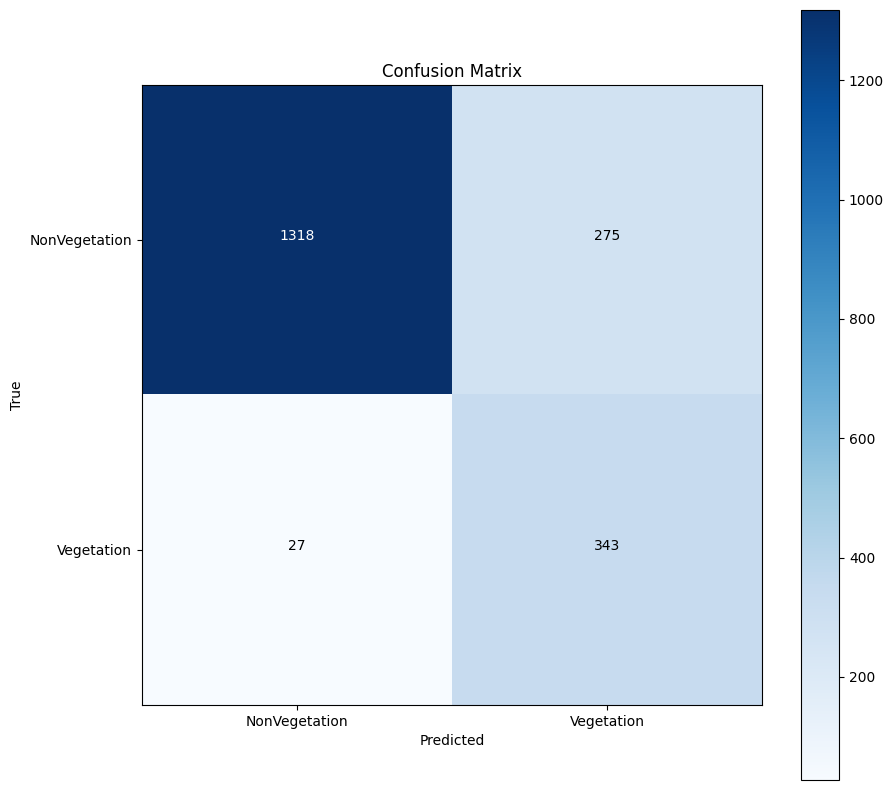

In [9]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image as keras_image
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix  # Make sure to import this




# Load the best model weights
best_weights_path = r"C:\Users\abudh\Desktop\CropWatch\16_08_FInal\best_weights_16_08_Platform1_.weights.h5"
model = ResNet50(input_shape=(224, 224, 3))
model.load_weights(best_weights_path)

# Define paths
NonVeg = glob.glob(r'C:\Users\abudh\Desktop\CropWatch\Platform1_D2\DataSet2\NonVegetation_Augmented\*.jpeg')
Veg = glob.glob(r'C:\Users\abudh\Desktop\CropWatch\Platform1_D2\DataSet2\Vegetation_Augmented\*.jpeg')

# Initialize lists for predictions
NonVeg_pred = []
Veg_pred = []

# Function to load and preprocess image
def load_and_preprocess_image(image_path, target_size):
    img = keras_image.load_img(image_path, target_size=target_size)
    img_array = keras_image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Predict Non-Vegetation Images
for image in NonVeg:
    img_array = load_and_preprocess_image(image, target_size=(224, 224))
    pred = model.predict(img_array)
    NonVeg_pred.append(int(pred > 0.5))  # Use threshold of 0.5 for binary classification

# Predict Vegetation Images
for image in Veg:
    img_array = load_and_preprocess_image(image, target_size=(224, 224))
    pred = model.predict(img_array)
    Veg_pred.append(int(pred > 0.5))  # Use threshold of 0.5 for binary classification

# True labels and predicted labels
true_labels = [0] * len(NonVeg_pred) + [1] * len(Veg_pred)
predicted_labels = NonVeg_pred + Veg_pred

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.title('Confusion Matrix')
class_names = ['NonVegetation', 'Vegetation']  # Define class names
plt.xticks(np.arange(len(class_names)), class_names)
plt.yticks(np.arange(len(class_names)), class_names)

# Annotate the confusion matrix with the actual numbers
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f'{cm[i, j]}', horizontalalignment='center', color='white' if cm[i, j] > cm.max()/2 else 'black')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


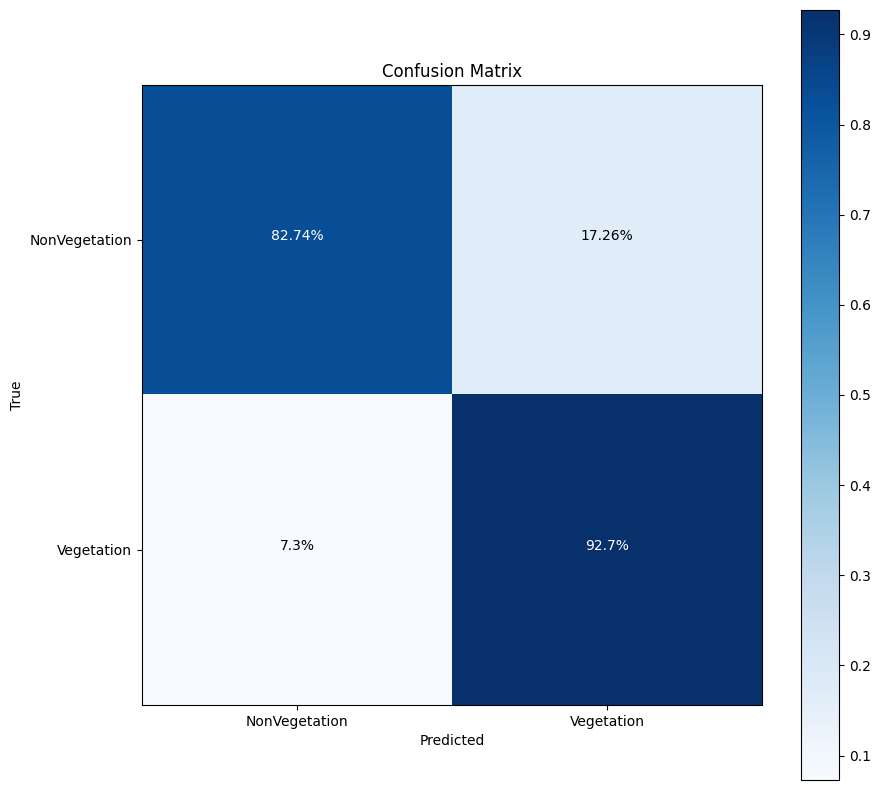

In [23]:
# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.title('Confusion Matrix')
class_names = ['NonVegetation', 'Vegetation']  # Define class names
plt.xticks(np.arange(len(class_names)), class_names)
plt.yticks(np.arange(len(class_names)), class_names)

# Annotate the confusion matrix with the actual numbers
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f'{round(100*cm[i, j], 2)}%', horizontalalignment='center', 
             color='white' if cm[i, j] > cm.max()/2 else 'black')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [25]:

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image as keras_image
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import glob

# Classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:")
print(report)

# ROC Curve
fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

Classification Report:
               precision    recall  f1-score   support

NonVegetation       0.98      0.83      0.90      1593
   Vegetation       0.56      0.93      0.69       370

     accuracy                           0.85      1963
    macro avg       0.77      0.88      0.80      1963
 weighted avg       0.90      0.85      0.86      1963



NameError: name 'predicted_probs' is not defined

In [19]:
# Load the best model weights
best_weights_path = r'C:\Users\abudh\Desktop\CropWatch\best_weights_16_08_Platform1_.weights.h5'
model = ResNet50(input_shape=(224, 224, 3))
model.load_weights(best_weights_path)

# Step 4: Load and preprocess images
test_folder = r"C:\Users\abudh\Desktop\CropWatch\Test_15_08"
batch_size = 64
img_height = 224
img_width = 224
rescale = 1.0 / 255

def load_images_from_folder(folder_path, img_height, img_width, rescale):
    images = []
    filenames = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        if os.path.isfile(img_path):
            img = keras_image.load_img(img_path, target_size=(img_height, img_width))
            img_array = keras_image.img_to_array(img) * rescale
            images.append(img_array)
            filenames.append(filename)
    return np.array(images), filenames

# Load images from the test folder
test_images, test_filenames = load_images_from_folder(test_folder, img_height, img_width, rescale)

# Use the model to make predictions
predictions = model.predict(test_images)
predicted_classes = np.round(predictions).astype(int).flatten()

# Display images with predictions
num_images = len(test_filenames)
images_per_column = 100
num_columns = (num_images + images_per_column - 1) // images_per_column

plt.figure(figsize=(num_columns * 4, images_per_column * 3))

for i in range(num_images):
    predicted_label = predicted_classes[i]
    label_str = 'Predicted: {}'.format('Vegetation' if predicted_label == 1 else 'Non-Vegetation')
    
    plt.subplot(images_per_column, num_columns, i + 1)
    plt.imshow(test_images[i])
    plt.title(label_str, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'C:\Users\abudh\Desktop\CropWatch\best_weights_16_08_Platform1_.weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

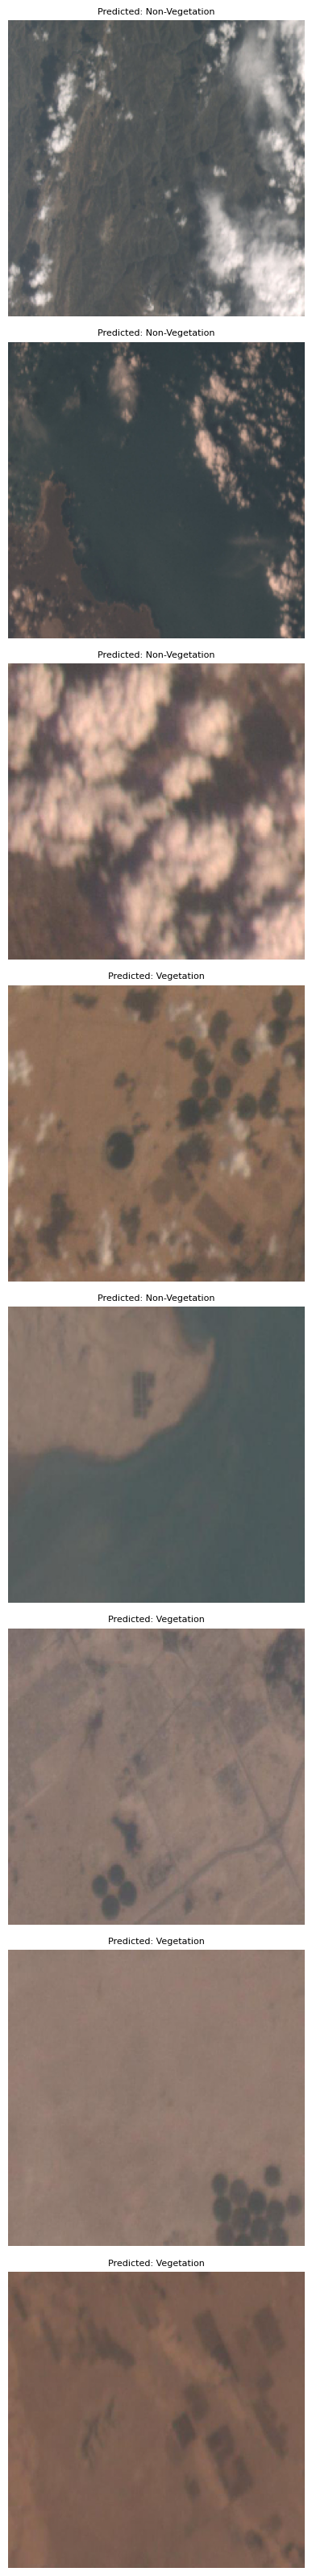

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image as keras_image

# Load the TFLite model
tflite_model_path = r'C:\Users\abudh\Desktop\CropWatch\16_08_FInal\best_model_Platform1A.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Extract input shape
input_shape = input_details[0]['shape']
img_height, img_width = input_shape[1], input_shape[2]
rescale = 1.0 / 255

def load_images_from_folder(folder_path, img_height, img_width, rescale):
    images = []
    filenames = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        if os.path.isfile(img_path):
            img = keras_image.load_img(img_path, target_size=(img_height, img_width))
            img_array = keras_image.img_to_array(img) * rescale
            images.append(img_array)
            filenames.append(filename)
    return np.array(images), filenames

# Load images from the test folder
test_folder = r"C:\Users\abudh\Desktop\CropWatch\Test_15_08"
test_images, test_filenames = load_images_from_folder(test_folder, img_height, img_width, rescale)

# Make predictions using the TFLite model
def predict_with_tflite_model(interpreter, images):
    predictions = []
    for img in images:
        # Prepare the image for the model
        input_data = np.expand_dims(img, axis=0).astype(np.float32)
        
        # Set the input tensor
        interpreter.set_tensor(input_details[0]['index'], input_data)
        
        # Run the model
        interpreter.invoke()
        
        # Get the output tensor
        output_data = interpreter.get_tensor(output_details[0]['index'])
        predictions.append(output_data)
    
    return np.array(predictions).flatten()

# Predict class probabilities for the test images
predictions = predict_with_tflite_model(interpreter, test_images)
predicted_classes = np.round(predictions).astype(int)

# Display images with predictions
num_images = len(test_filenames)
images_per_column = 10  # Adjust as needed
num_columns = (num_images + images_per_column - 1) // images_per_column

plt.figure(figsize=(num_columns * 4, images_per_column * 4))

for i in range(num_images):
    predicted_label = predicted_classes[i]
    label_str = 'Predicted: {}'.format('Vegetation' if predicted_label == 1 else 'Non-Vegetation')
    
    plt.subplot(images_per_column, num_columns, i + 1)
    plt.imshow(test_images[i])
    plt.title(label_str, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()


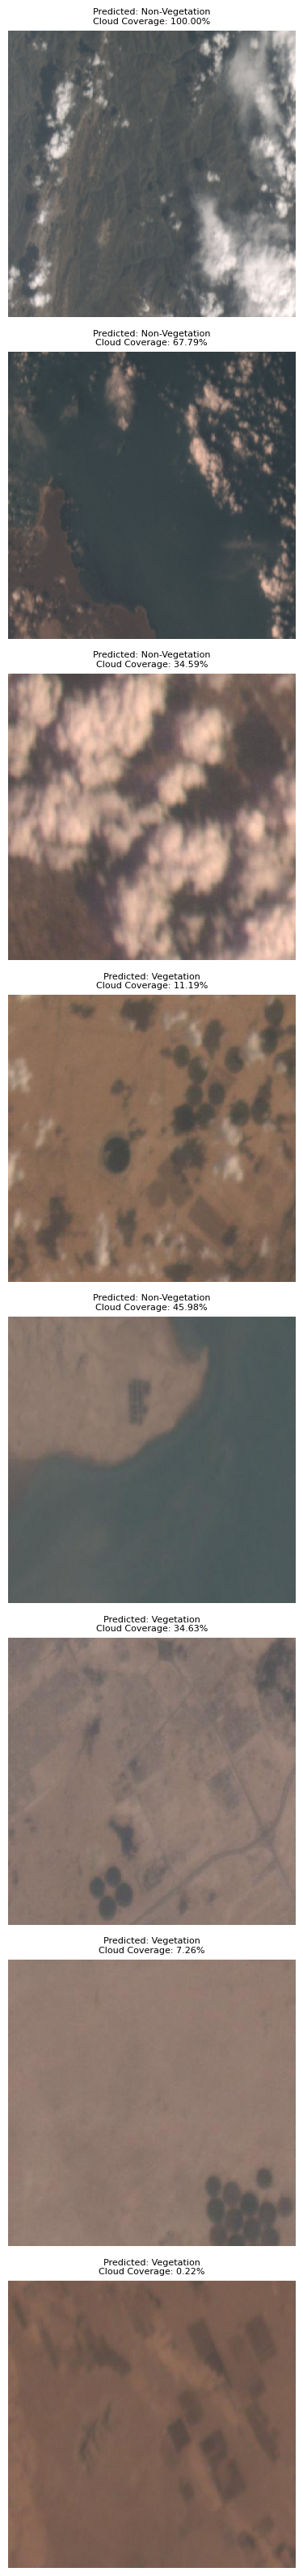

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image as keras_image
import cv2

# Load the TFLite model
tflite_model_path = r'C:\Users\abudh\Desktop\CropWatch\16_08_FInal\best_model_Platform1A.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Extract input shape
input_shape = input_details[0]['shape']
img_height, img_width = input_shape[1], input_shape[2]
rescale = 1.0 / 255

def load_images_from_folder(folder_path, img_height, img_width, rescale):
    images = []
    filenames = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        if os.path.isfile(img_path):
            img = keras_image.load_img(img_path, target_size=(img_height, img_width))
            img_array = keras_image.img_to_array(img) * rescale
            images.append(img_array)
            filenames.append(filename)
    return np.array(images), filenames

# Define the cloud detection function
def calculate_cloud_coverage(image, t1=0.1, t2=0.1, kernel_size=10):
    """Calculates the cloud coverage percentage in the image."""
    kernel = np.ones((kernel_size, kernel_size), dtype=np.uint8)
    
    # Convert the image from RGB to BGR for OpenCV processing
    image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    # Extract color channels
    R = image[:, :, 2].astype(float)
    G = image[:, :, 1].astype(float)
    B = image[:, :, 0].astype(float)
    
    # Calculate ratios
    rg = R / (G + 1e-10)  # Avoid division by zero
    gb = G / (B + 1e-10)  # Avoid division by zero

    # Create a cloud mask based on color ratios
    cloud_mask1 = np.logical_and(np.abs(rg - 1) < t1, np.abs(gb - 1) < t2).astype(np.uint8)
    cloud_mask = cv2.dilate(cloud_mask1, kernel=kernel, iterations=1)
    
    # Calculate cloud coverage percentage
    cloud_cover = np.sum(cloud_mask) / cloud_mask.size * 100

    return cloud_cover

# Load images from the test folder
test_folder = r"C:\Users\abudh\Desktop\CropWatch\Test_15_08"
test_images, test_filenames = load_images_from_folder(test_folder, img_height, img_width, rescale)

# Make predictions using the TFLite model
def predict_with_tflite_model(interpreter, images):
    predictions = []
    for img in images:
        # Prepare the image for the model
        input_data = np.expand_dims(img, axis=0).astype(np.float32)
        
        # Set the input tensor
        interpreter.set_tensor(input_details[0]['index'], input_data)
        
        # Run the model
        interpreter.invoke()
        
        # Get the output tensor
        output_data = interpreter.get_tensor(output_details[0]['index'])
        predictions.append(output_data)
    
    return np.array(predictions).flatten()

# Predict class probabilities for the test images
predictions = predict_with_tflite_model(interpreter, test_images)
predicted_classes = np.round(predictions).astype(int)

# Display images with predictions and cloud coverage
num_images = len(test_filenames)
images_per_column = 10  # Adjust as needed
num_columns = (num_images + images_per_column - 1) // images_per_column

plt.figure(figsize=(num_columns * 4, images_per_column * 4))

for i in range(num_images):
    predicted_label = predicted_classes[i]
    label_str = 'Predicted: {}'.format('Vegetation' if predicted_label == 1 else 'Non-Vegetation')
    
    # Calculate cloud coverage
    cloud_coverage = calculate_cloud_coverage(test_images[i])
    label_str += f'\nCloud Coverage: {cloud_coverage:.2f}%'
    
    plt.subplot(images_per_column, num_columns, i + 1)
    plt.imshow(test_images[i])
    plt.title(label_str, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()


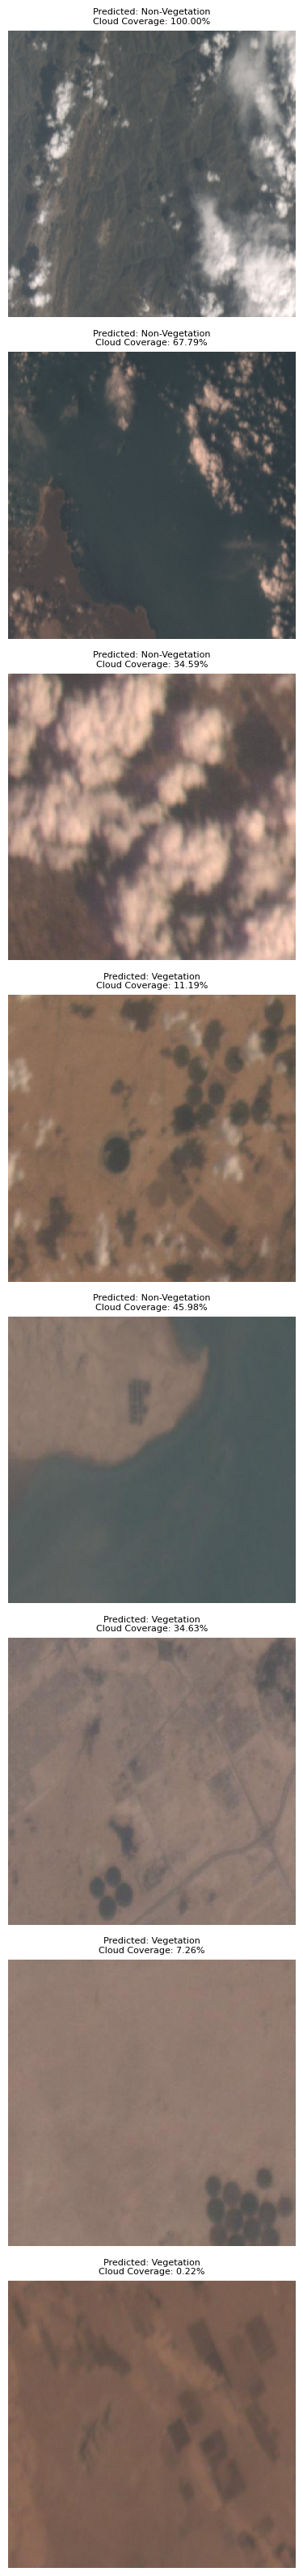

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image as keras_image
import cv2
from PIL import Image

# Load the TFLite model
tflite_model_path = r'C:\Users\abudh\Desktop\CropWatch\16_08_FInal\best_model_Platform1A.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Extract input shape
input_shape = input_details[0]['shape']
img_height, img_width = input_shape[1], input_shape[2]
rescale = 1.0 / 255

def load_images_from_folder(folder_path, img_height, img_width, rescale):
    images = []
    filenames = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        if os.path.isfile(img_path):
            img = keras_image.load_img(img_path, target_size=(img_height, img_width))
            img_array = keras_image.img_to_array(img) * rescale
            images.append(img_array)
            filenames.append(filename)
    return np.array(images), filenames

# Define the cloud detection function
def calculate_cloud_coverage(image, t1=0.1, t2=0.1, kernel_size=10):
    """Calculates the cloud coverage percentage in the image."""
    kernel = np.ones((kernel_size, kernel_size), dtype=np.uint8)
    
    # Convert the image from RGB to BGR for OpenCV processing
    image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    # Extract color channels
    R = image[:, :, 2].astype(float)
    G = image[:, :, 1].astype(float)
    B = image[:, :, 0].astype(float)
    
    # Calculate ratios
    rg = R / (G + 1e-10)  # Avoid division by zero
    gb = G / (B + 1e-10)  # Avoid division by zero

    # Create a cloud mask based on color ratios
    cloud_mask1 = np.logical_and(np.abs(rg - 1) < t1, np.abs(gb - 1) < t2).astype(np.uint8)
    cloud_mask = cv2.dilate(cloud_mask1, kernel=kernel, iterations=1)
    
    # Calculate cloud coverage percentage
    cloud_cover = np.sum(cloud_mask) / cloud_mask.size * 100

    return cloud_cover

# Load images from the test folder
test_folder = r"C:\Users\abudh\Desktop\CropWatch\Test_15_08"
test_images, test_filenames = load_images_from_folder(test_folder, img_height, img_width, rescale)

# Make predictions using the TFLite model
def predict_with_tflite_model(interpreter, images):
    predictions = []
    for img in images:
        # Prepare the image for the model
        input_data = np.expand_dims(img, axis=0).astype(np.float32)
        
        # Set the input tensor
        interpreter.set_tensor(input_details[0]['index'], input_data)
        
        # Run the model
        interpreter.invoke()
        
        # Get the output tensor
        output_data = interpreter.get_tensor(output_details[0]['index'])
        predictions.append(output_data)
    
    return np.array(predictions).flatten()

# Predict class probabilities for the test images
predictions = predict_with_tflite_model(interpreter, test_images)
predicted_classes = np.round(predictions).astype(int)

# Display images with predictions and cloud coverage
num_images = len(test_filenames)
images_per_column = 10  # Adjust as needed
num_columns = (num_images + images_per_column - 1) // images_per_column

plt.figure(figsize=(num_columns * 4, images_per_column * 4))

for i in range(num_images):
    predicted_label = predicted_classes[i]
    label_str = 'Predicted: {}'.format('Vegetation' if predicted_label == 1 else 'Non-Vegetation')
    
    # Calculate cloud coverage
    cloud_coverage = calculate_cloud_coverage(test_images[i])
    label_str += f'\nCloud Coverage: {cloud_coverage:.2f}%'
    
    plt.subplot(images_per_column, num_columns, i + 1)
    plt.imshow(test_images[i])
    plt.title(label_str, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Save images classified as vegetation
FILTERED_IMAGE_FOLDER = r'C:\Users\abudh\Desktop\CropWatch\Filtered_Image_Platform1'
save_vegetation_images(test_images, test_filenames, predicted_classes, FILTERED_IMAGE_FOLDER, threshold=1)


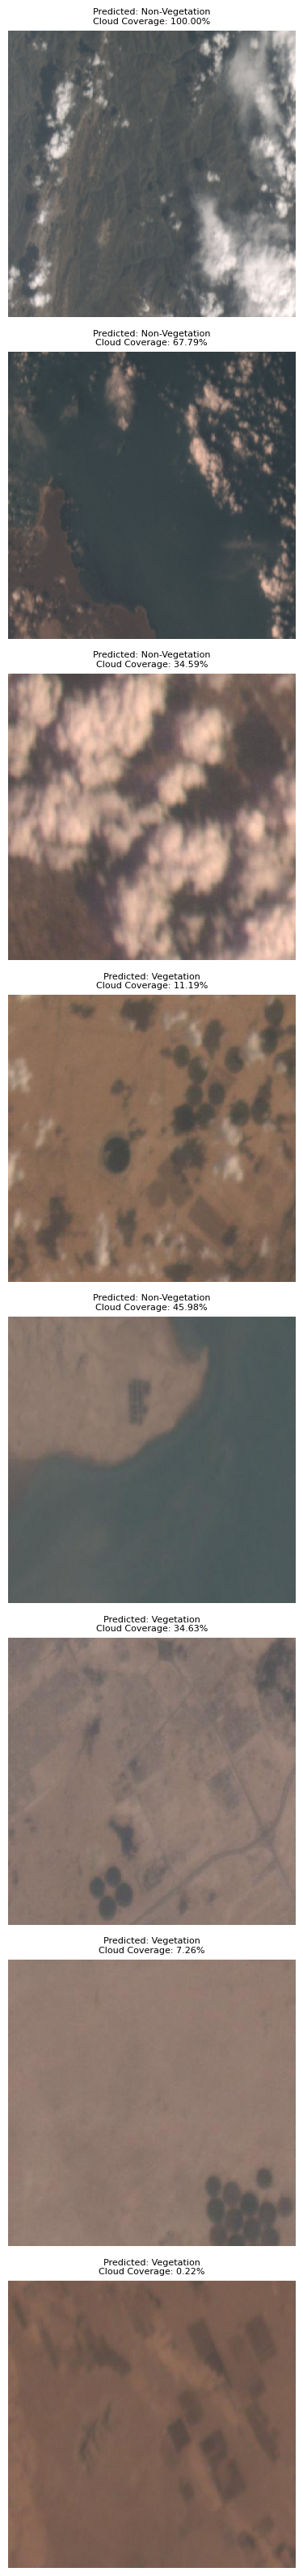

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image as keras_image
import cv2
from PIL import Image

# Load the TFLite model
tflite_model_path = r'C:\Users\abudh\Desktop\CropWatch\16_08_FInal\best_model_Platform1A.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Extract input shape
input_shape = input_details[0]['shape']
img_height, img_width = input_shape[1], input_shape[2]
rescale = 1.0 / 255

def load_images_from_folder(folder_path, img_height, img_width, rescale):
    images = []
    filenames = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        if os.path.isfile(img_path):
            img = keras_image.load_img(img_path, target_size=(img_height, img_width))
            img_array = keras_image.img_to_array(img) * rescale
            images.append(img_array)
            filenames.append(filename)
    return np.array(images), filenames

# Define the cloud detection function
def calculate_cloud_coverage(image, t1=0.1, t2=0.1, kernel_size=10):
    """Calculates the cloud coverage percentage in the image."""
    kernel = np.ones((kernel_size, kernel_size), dtype=np.uint8)
    
    # Convert the image from RGB to BGR for OpenCV processing
    image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    # Extract color channels
    R = image[:, :, 2].astype(float)
    G = image[:, :, 1].astype(float)
    B = image[:, :, 0].astype(float)
    
    # Calculate ratios
    rg = R / (G + 1e-10)  # Avoid division by zero
    gb = G / (B + 1e-10)  # Avoid division by zero

    # Create a cloud mask based on color ratios
    cloud_mask1 = np.logical_and(np.abs(rg - 1) < t1, np.abs(gb - 1) < t2).astype(np.uint8)
    cloud_mask = cv2.dilate(cloud_mask1, kernel=kernel, iterations=1)
    
    # Calculate cloud coverage percentage
    cloud_cover = np.sum(cloud_mask) / cloud_mask.size * 100

    return cloud_cover

def splice_image(image):
    """Splice the image into four equal parts: top-left, top-right, bottom-left, bottom-right."""
    h, w, _ = image.shape
    mid_h, mid_w = h // 2, w // 2
    
    # Define the four parts
    top_left = image[:mid_h, :mid_w]
    top_right = image[:mid_h, mid_w:]
    bottom_left = image[mid_h:, :mid_w]
    bottom_right = image[mid_h:, mid_w:]
    
    return top_left, top_right, bottom_left, bottom_right

def save_spliced_images(image, filename, save_folder):
    """Save the four spliced parts of an image."""
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    
    # Splice the image
    top_left, top_right, bottom_left, bottom_right = splice_image(image)
    
    # Save each part
    Image.fromarray((top_left * 255).astype(np.uint8)).save(os.path.join(save_folder, f'{filename}_top_left.png'))
    Image.fromarray((top_right * 255).astype(np.uint8)).save(os.path.join(save_folder, f'{filename}_top_right.png'))
    Image.fromarray((bottom_left * 255).astype(np.uint8)).save(os.path.join(save_folder, f'{filename}_bottom_left.png'))
    Image.fromarray((bottom_right * 255).astype(np.uint8)).save(os.path.join(save_folder, f'{filename}_bottom_right.png'))

def save_vegetation_images(images, filenames, predicted_classes, save_folder, threshold=1):
    """Save images classified as vegetation."""
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    
    for img, filename, pred in zip(images, filenames, predicted_classes):
        if pred >= threshold:  # Save only vegetation images
            save_path = os.path.join(save_folder, filename)
            img_to_save = Image.fromarray((img * 255).astype(np.uint8))
            img_to_save.save(save_path)

# Load images from the test folder
test_folder = r"C:\Users\abudh\Desktop\CropWatch\Test_15_08"
test_images, test_filenames = load_images_from_folder(test_folder, img_height, img_width, rescale)

# Make predictions using the TFLite model
def predict_with_tflite_model(interpreter, images):
    predictions = []
    for img in images:
        # Prepare the image for the model
        input_data = np.expand_dims(img, axis=0).astype(np.float32)
        
        # Set the input tensor
        interpreter.set_tensor(input_details[0]['index'], input_data)
        
        # Run the model
        interpreter.invoke()
        
        # Get the output tensor
        output_data = interpreter.get_tensor(output_details[0]['index'])
        predictions.append(output_data)
    
    return np.array(predictions).flatten()

# Predict class probabilities for the test images
predictions = predict_with_tflite_model(interpreter, test_images)
predicted_classes = np.round(predictions).astype(int)

# Display images with predictions and cloud coverage
num_images = len(test_filenames)
images_per_column = 10  # Adjust as needed
num_columns = (num_images + images_per_column - 1) // images_per_column

plt.figure(figsize=(num_columns * 4, images_per_column * 4))

for i in range(num_images):
    predicted_label = predicted_classes[i]
    label_str = 'Predicted: {}'.format('Vegetation' if predicted_label == 1 else 'Non-Vegetation')
    
    # Calculate cloud coverage
    cloud_coverage = calculate_cloud_coverage(test_images[i])
    label_str += f'\nCloud Coverage: {cloud_coverage:.2f}%'
    
    plt.subplot(images_per_column, num_columns, i + 1)
    plt.imshow(test_images[i])
    plt.title(label_str, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Save images classified as vegetation
FILTERED_IMAGE_FOLDER = r'C:\Users\abudh\Desktop\CropWatch\Filtered_Image_Platform1'
save_vegetation_images(test_images, test_filenames, predicted_classes, FILTERED_IMAGE_FOLDER, threshold=1)

# Save spliced images of the vegetation images
SPLICED_IMAGE_FOLDER = r'C:\Users\abudh\Desktop\CropWatch\Spliced_Image_Platform1'
for img, filename, pred in zip(test_images, test_filenames, predicted_classes):
    if pred == 1:  # Only process images classified as vegetation
        save_spliced_images(img, filename, SPLICED_IMAGE_FOLDER)
